***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine Conditioning


*Updated:* Mar 24, 2025


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [3]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,1,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    Theta["Theta_10"] = torch.zeros((n_dz[0],n_dz[1]+n_dz[0]-1),device=dev) # conditioning lower triangular
    return Phi,Theta

In [4]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [5]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [6]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [7]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -20
    return q

In [8]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [9]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [10]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [11]:
def data_layer_train(input_x,param_xy,param_yx,lr,dev):
    """
    Arguments:
    input_x -- Layer 0 sample, torch tensor of shape (n_d,batch_size)
    param_xy -- parameters from Layer 0 to Layer 1. Torch tensor of shape (n_z1,n_d)
    param_yx -- parameters from Layer 1 and sampled values at Layer 0 to Layer 0. Torch tensor of shape (n_d,n_z1 + n_d - 1)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    output_y -- Layer 1 sample, torch tensor of shape (n_z1,bzatch_size)
    param_yx -- updated parameters from Layer 1 and sampled values at Layer 0 to Layer 0
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev) # Layer 1
    
    # train the opposite phase from x to y
    n_d = input_x.shape[0]
    n_z1 = param_xy.shape[0]
    loss = torch.zeros(n_d,device=dev)
    samp = output_y
    for i in range(n_d):
        param_yx[i,:n_z1+i], grad, loss[i] = one_step_update(samp,input_x[i:i+1,:],param_yx[i,:n_z1+i],lr)
        samp = torch.cat((samp,input_x[i:i+1,:]),0) # (n_z1+i+1,batch_size)
    return output_y, param_yx, loss.mean()

In [12]:
def data_layer_gen(input_x,param_xy,param_yx,lr,dev):
    """
    Arguments:
    input_x -- Layer 1 sample, torch tensor of shape (n_z1,batch_size)
    param_xy -- parameters from Layer 1 and sampled values at Layer 0 to Layer 0. Torch tensor of shape (n_d,n_z1 + n_d - 1)
    param_yx -- parameters from Layer 0 to Layer 1. Torch tensor of shape (n_z1,n_d)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    n_d = param_xy.shape[0]
    n_z1 = input_x.shape[0]
    batch_size = input_x.shape[1]
    q = torch.zeros(n_d,batch_size,device=dev)
    output_y = torch.zeros(n_d,batch_size,device=dev,dtype=int)
    input_condition = input_x
    for i in range(n_d):
        q[i,:] = one_step_forward(input_condition,param_xy[i,:n_z1+i])
        output_y[i,:] = sample(q[i,:],dev)
        input_condition = torch.cat((input_condition,output_y[i:i+1,:]),0)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [13]:
def wake_phase(Phi,Theta,data,lr,dev,cor):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    cor -- add data layer correlation or not. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    n_z1 = Phi["Phi_01"].shape[0]
    if cor == True:
        output_y, Theta["Theta_10"], Loss[0] = data_layer_train(data,Phi["Phi_01"],Theta["Theta_10"],lr,dev)
    else:
        output_y, Theta["Theta_10"][:,:n_z1], Grad, Loss[0] = layer_wise_train(data,Phi["Phi_01"],Theta["Theta_10"][:,:n_z1],lr)
    input_x = output_y
    for i in range(1,n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [14]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
                    sample is of shape (n_y, batch_size)
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = sample(one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)]),dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [15]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev,cor):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    cor -- add data layer correlation or not. Boolean value True or False.
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    n_z1 = Phi["Phi_01"].shape[0]
    for i in range(n_layer-2,1,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    if cor == True:
        output_y, Phi["Phi_01"], Grad, Loss[1] = data_layer_gen(input_x,Theta["Theta_10"],Phi["Phi_01"],lr,dev)
    else:
        output_y, Phi["Phi_01"], Grad, Loss[1] = layer_wise_train(input_x,Theta["Theta_10"][:,:n_z1],Phi["Phi_01"],lr)
    return Phi, Loss

In [16]:
def sleep_sample(Theta,gen_batch_size,dev,cor):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    cor -- add data layer correlation or not. Boolean value True or False.
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    n_d = Theta["Theta_10"].shape[0]
    n_z1 = Theta["Theta_21"].shape[0]
    for i in range(n_layer-1,1,-1):
        input_x = sample(one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)]),dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    if cor == False:
        Gen_sample["Layer_0"] = sample(one_step_forward(input_x,Theta["Theta_10"][:,:n_z1]),dev)
    else:
        q = torch.zeros(n_d,gen_batch_size,device=dev)
        Gen_sample["Layer_0"] = torch.zeros(n_d,gen_batch_size,device=dev,dtype=int)
        input_condition = input_x
        for i in range(n_d):
            q[i,:] = one_step_forward(input_condition,Theta["Theta_10"][i,:n_z1+i])
            Gen_sample["Layer_0"][i,:] = sample(q[i,:],dev)
            input_condition = torch.cat((input_condition,Gen_sample["Layer_0"][i:i+1,:]),0)
    return Gen_sample

In [17]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    dcm = (2**torch.arange(width).flip(0).to(dev).reshape(-1,1) * bnr).sum(axis=0)
    return dcm

In [18]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [19]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

In [20]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [21]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [22]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [23]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [24]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    I -- mutual information between layers X and Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    I = H_Y - H_YX
    return H_Y, I

In [25]:
def wake_entropy(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    H_Y_wake -- factorial entropy at layers 1,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_wake -- mutual information between layers [0,1],...,[n_layer-3,n_layer-2]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Phi) + 2
    H_Y_wake = torch.zeros(n_layer-2)
    I_wake = torch.zeros(n_layer-2)
    input_x = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], I_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    return H_Y_wake, I_wake

In [26]:
def sleep_entropy(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    H_Y_sleep -- factorial entropy at layers 0,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_sleep -- mutual information between layers [1,0],...,[n_layer-2,n_layer-3]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Theta) + 1
    H_Y_sleep = torch.zeros(n_layer-1)
    I_sleep = torch.zeros(n_layer-1)
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,1,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], I_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    
    n_d = Theta["Theta_10"].shape[0]
    n_z1 = Theta["Theta_21"].shape[0]
    q = torch.zeros(n_d,gen_batch_size,device=dev)
    input_condition = input_x
    for i in range(n_d):
        q[i,:] = one_step_forward(input_condition,Theta["Theta_10"][i,:n_z1+i])
        input_condition = torch.cat((input_condition,sample(q[i:i+1,:],dev)),0)  
    H_Y_sleep[0], I_sleep[0] = one_step_prob_entropy(q)    
    I_sleep = I_sleep[:-1]
    return H_Y_sleep, I_sleep

In [27]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

In [28]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

## 1. Well-formed Dataset

In [29]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_layer = len(n_dz)
n_d = n_dz[0]

In [30]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [31]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [32]:
Phi,Theta = para_init(n_dz,dev)

In [33]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [34]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

In [35]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785], device='cuda:0')

In [36]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Data_D_KL')
col_list.append('Gen_D_KL')
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Data_D_KL',
 'Gen_D_KL',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Recog_I_Layer_4',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_H_Layer_4',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen_I_Layer_3',
 'Gen_I_Layer_4']

In [37]:
len(col_list)

28

### Train with Batch

In [38]:
Analytic_well_formed_batch_cor = pd.DataFrame(columns=col_list)
Analytic_well_formed_batch_cor

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4


In [39]:
Phi,Theta = para_init(n_dz,dev)

In [46]:
Analytic_well_formed_batch_cor = pd.read_csv('Analytic_well_formed_batch_1000.csv', sep=",")
Analytic_well_formed_batch_cor

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,8.517877,...,4.768372e-07,8.314627,6.931460,5.545170,4.158881,2.079441,0.000320,0.000004,0.000002,0.000002
1,0.686657,0.690722,0.692021,0.690250,0.612048,0.684426,0.690240,0.692160,0.691834,3.726403,...,6.158352e-04,7.408446,6.852787,5.526151,4.154981,2.076340,0.033911,0.009284,0.003294,0.001352
2,0.681345,0.687987,0.689541,0.682218,0.611148,0.684541,0.688435,0.690330,0.686892,3.644928,...,3.796577e-03,7.390693,6.846466,5.510879,4.144400,2.058817,0.045403,0.010573,0.005669,0.004341
3,0.674804,0.685975,0.686745,0.673212,0.601985,0.683548,0.686984,0.684644,0.681567,3.512707,...,6.826639e-03,7.381727,6.844646,5.496471,4.127330,2.035040,0.121571,0.011034,0.007671,0.008052
4,0.658424,0.682750,0.682672,0.658611,0.584376,0.682454,0.683092,0.680933,0.665884,3.184795,...,1.136386e-02,7.373665,6.826271,5.477844,4.104737,1.996639,0.299424,0.013454,0.009907,0.011582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.271716,0.310264,0.432966,0.270934,0.328376,0.362357,0.501787,0.477288,0.312423,0.806547,...,1.390948e-01,7.331074,5.763642,4.515958,3.004580,0.970503,3.319494,2.152582,0.472152,0.147140
296,0.260382,0.316298,0.440284,0.273875,0.335606,0.362537,0.503525,0.482458,0.337231,0.819698,...,1.398342e-01,7.334057,5.749758,4.530286,3.009424,0.952790,3.319715,2.145312,0.466810,0.147744
297,0.275693,0.320972,0.415885,0.265929,0.331445,0.360725,0.509912,0.480037,0.326177,0.856983,...,1.404952e-01,7.333416,5.739731,4.528586,2.995581,0.958538,3.315529,2.142926,0.473226,0.148277
298,0.261871,0.307567,0.426167,0.264653,0.334584,0.349791,0.513359,0.479839,0.314011,0.803331,...,1.381564e-01,7.330891,5.743494,4.529022,2.988256,0.946234,3.308731,2.145641,0.466351,0.146293


In [47]:
para = torch.load('Parameters_well_formed_batch_1000',dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [43]:
# Theta['Theta_10'] = torch.cat((Theta['Theta_10'],torch.zeros(n_d,n_d-1,device=dev)),1)
Theta['Theta_10'].shape

torch.Size([12, 21])

In [52]:
batch_size = n_data
data = well_formed_set
gen_batch_size = 100000
lr = 0.1
epoch = 100000
n_data

905

In [53]:
for e in range(epoch):
#     if e%2 == 0:
    Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,cor=True)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev,cor=True)
#     else:
#         Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,cor=False)
#         Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev,cor=False)
    if e%1000 == 0:
        print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
        stat = []
        stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
        stat = stat + list((Loss_sleep).to('cpu').numpy())
        
        gen_data = sleep_sample(Theta,gen_batch_size,dev,cor=True)["Layer_0"]
        gen_dcm = decimalize(gen_data,dev)
        values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=counts_g/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())
        
        k = 0
        for i in range(gen_batch_size):
            if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
                k += 1
        stat.append(k/gen_batch_size)
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,50),dev) # batch_size = 50000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
        Analytic_well_formed_batch_cor.loc[len(Analytic_well_formed_batch_cor)] = stat

Loss_wake: tensor([0.0000, 0.2603, 0.3077, 0.4056, 0.2703])     Loss_sleep: tensor([0.3355, 0.3544, 0.4921, 0.4602, 0.2660])
Loss_wake: tensor([0.0000, 0.2638, 0.3108, 0.4140, 0.2478])     Loss_sleep: tensor([0.3256, 0.3510, 0.4998, 0.4662, 0.3018])
Loss_wake: tensor([0.0000, 0.2639, 0.3164, 0.4107, 0.2558])     Loss_sleep: tensor([0.3370, 0.3585, 0.4930, 0.4632, 0.3011])
Loss_wake: tensor([0.0000, 0.2672, 0.3162, 0.4081, 0.2608])     Loss_sleep: tensor([0.3360, 0.3577, 0.4993, 0.4725, 0.2957])
Loss_wake: tensor([0.0000, 0.2558, 0.3126, 0.4036, 0.2407])     Loss_sleep: tensor([0.3299, 0.3553, 0.5049, 0.4615, 0.2883])
Loss_wake: tensor([0.0000, 0.2461, 0.3035, 0.4061, 0.2427])     Loss_sleep: tensor([0.3298, 0.3609, 0.4976, 0.4616, 0.2841])
Loss_wake: tensor([0.0000, 0.2522, 0.3238, 0.4126, 0.2487])     Loss_sleep: tensor([0.3344, 0.3563, 0.4992, 0.4750, 0.2904])
Loss_wake: tensor([0.0000, 0.2594, 0.3206, 0.4170, 0.2594])     Loss_sleep: tensor([0.3337, 0.3452, 0.5056, 0.4585, 0.2988])


KeyboardInterrupt: 

In [54]:
Analytic_well_formed_batch_cor

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,8.517877,...,4.768372e-07,8.314627,6.931460,5.545170,4.158881,2.079441,0.000320,0.000004,0.000002,0.000002
1,0.686657,0.690722,0.692021,0.690250,0.612048,0.684426,0.690240,0.692160,0.691834,3.726403,...,6.158352e-04,7.408446,6.852787,5.526151,4.154981,2.076340,0.033911,0.009284,0.003294,0.001352
2,0.681345,0.687987,0.689541,0.682218,0.611148,0.684541,0.688435,0.690330,0.686892,3.644928,...,3.796577e-03,7.390693,6.846466,5.510879,4.144400,2.058817,0.045403,0.010573,0.005669,0.004341
3,0.674804,0.685975,0.686745,0.673212,0.601985,0.683548,0.686984,0.684644,0.681567,3.512707,...,6.826639e-03,7.381727,6.844646,5.496471,4.127330,2.035040,0.121571,0.011034,0.007671,0.008052
4,0.658424,0.682750,0.682672,0.658611,0.584376,0.682454,0.683092,0.680933,0.665884,3.184795,...,1.136386e-02,7.373665,6.826271,5.477844,4.104737,1.996639,0.299424,0.013454,0.009907,0.011582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.251868,0.316527,0.410392,0.268275,0.332137,0.366553,0.497466,0.465560,0.294487,0.677869,...,1.317491e-01,7.335526,5.701438,4.491810,2.924160,0.875635,3.359627,2.144290,0.469572,0.139247
326,0.257132,0.312018,0.412972,0.243740,0.326479,0.357293,0.509497,0.471025,0.285421,0.664728,...,1.354845e-01,7.333112,5.707237,4.509664,2.947655,0.881995,3.355841,2.157112,0.479871,0.141514
327,0.258495,0.314221,0.408657,0.245219,0.325884,0.358253,0.508138,0.463709,0.287413,0.656104,...,1.331169e-01,7.332712,5.684342,4.499578,2.916951,0.886251,3.349450,2.144201,0.473807,0.141391
328,0.255879,0.319355,0.414813,0.232300,0.331659,0.348567,0.504297,0.468771,0.299326,0.661331,...,1.377692e-01,7.332651,5.694893,4.489432,2.919247,0.889228,3.352013,2.158233,0.468841,0.143123


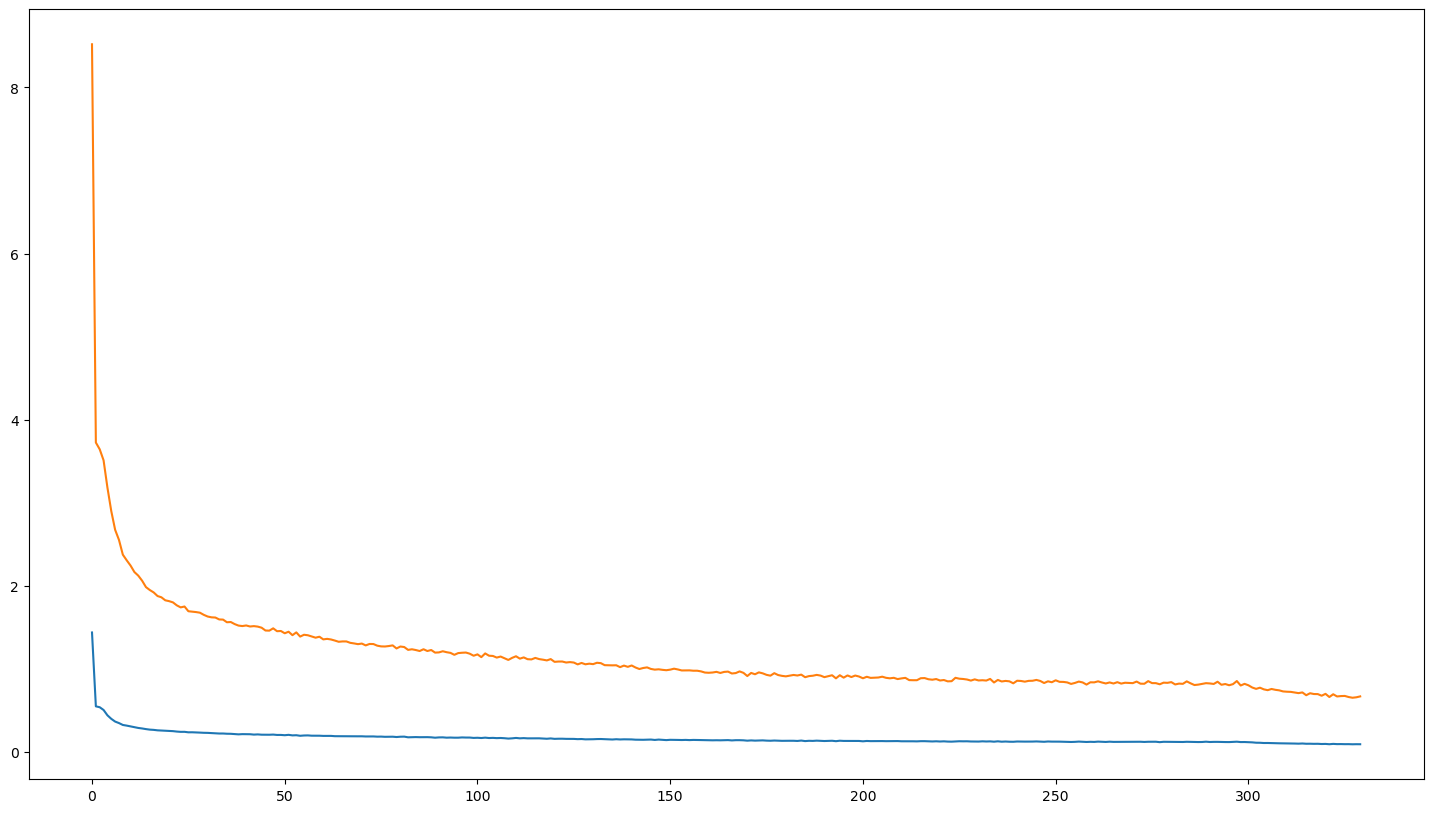

In [55]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_well_formed_batch_cor['Gen_D_KL']))
ax.plot(np.array(Analytic_well_formed_batch_cor['Data_D_KL']))
plt.show()

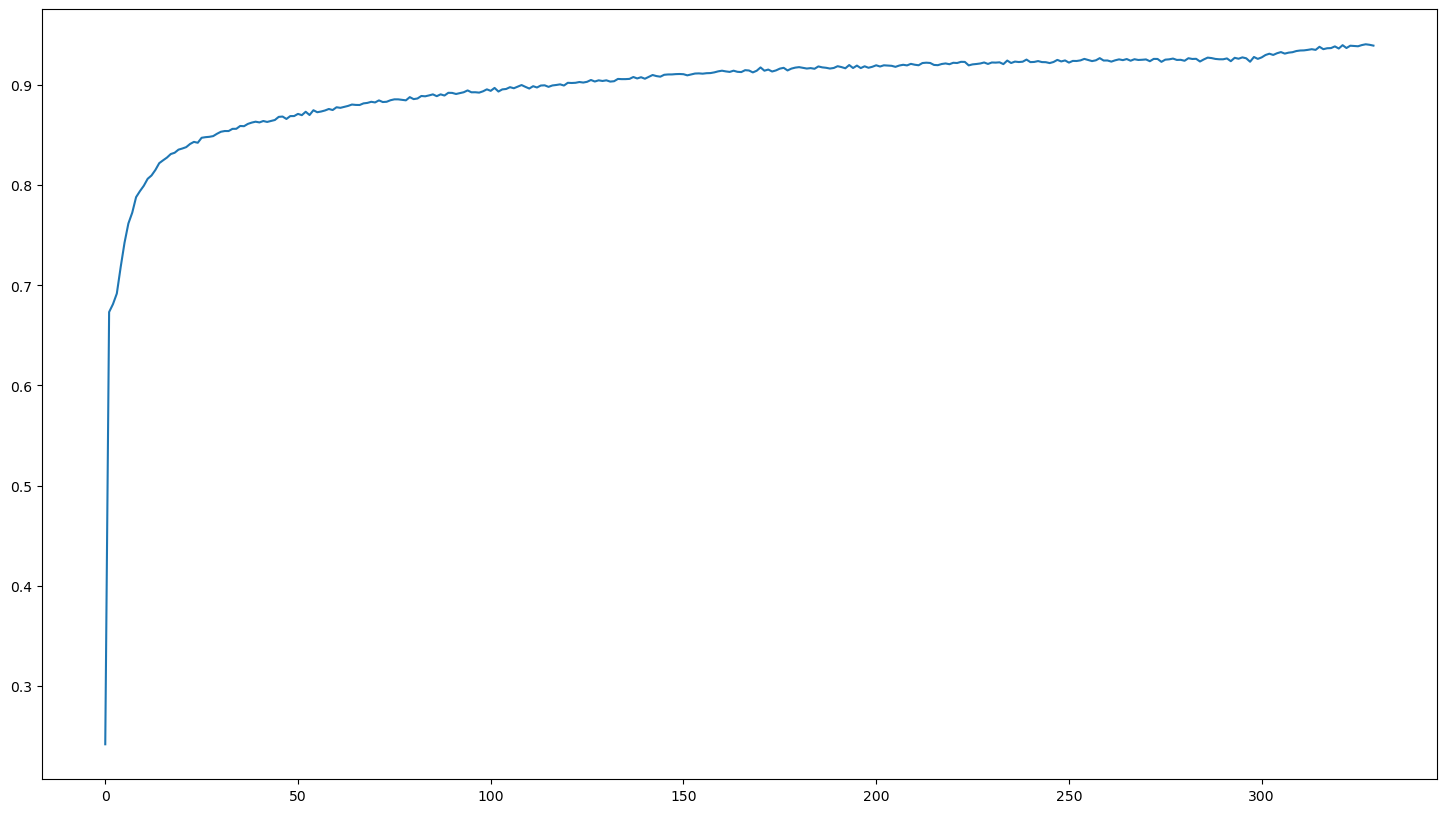

In [56]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_well_formed_batch_cor['Accuracy']))
plt.show()

In [83]:
# Analytic_ws_online.dtypes

In [126]:
parameters = {'Phi': Phi, 'Theta': Theta}
torch.save(parameters,'Parameters_well_formed_batch_cor')

In [127]:
Analytic_well_formed_batch_cor.to_csv('Analytic_well_formed_batch_cor.csv', index = False)

In [128]:
wake_dict = wake_sample(Phi,data,dev)
Dist_wake = {}
for key in wake_dict:
    sample_w = wake_dict[key]
    values_g,counts_g = torch.unique(decimalize(sample_w,dev),return_counts=True)
    dist = torch.zeros(2**sample_w.shape[0],device=dev)
    dist[values_g]=counts_g/sample_w.shape[1]
    Dist_wake[key] = dist

In [129]:
sleep_dict = sleep_sample(Theta,gen_batch_size,dev,cor=True)
Dist_sleep = {}
for key in sleep_dict:
    sample_s = sleep_dict[key]
    values_g,counts_g = torch.unique(decimalize(sample_s,dev),return_counts=True)
    dist = torch.zeros(2**sample_s.shape[0],device=dev)
    dist[values_g]=counts_g/sample_s.shape[1]
    Dist_sleep[key] = dist

In [130]:
data_dcm = decimalize(well_formed_set,dev)
gen_dcm = decimalize(sleep_dict['Layer_0'],dev)
gen_dcm

tensor([3388, 3298, 3979,  ..., 2844, 2757, 3308], device='cuda:0')

In [131]:
k = 0
for i in range(gen_dcm.shape[0]):
    if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
        k += 1
k/gen_dcm.shape[0]

0.94955

Layer 0 Data_dist D_KL: 0.5671
Layer 0 Gen_dist D_KL: 0.0875
Layer 1 Recognition Distribution D_KL: 1.1161 H(Y): tensor(5.2292) H(Y|X): tensor(2.2623) I_XY: tensor(2.9669)
Layer 1 Generative  Distribution D_KL: 0.2272 H(Y): tensor(5.2281) H(Y|X): tensor(2.0093) I_XY: tensor(3.2187)
Layer 2 Recognition Distribution D_KL: 0.2759 H(Y): tensor(3.8475) H(Y|X): tensor(2.5276) I_XY: tensor(1.3199)
Layer 2 Generative  Distribution D_KL: 0.0694 H(Y): tensor(3.8497) H(Y|X): tensor(2.3836) I_XY: tensor(1.4661)
Layer 3 Recognition Distribution D_KL: 0.0918 H(Y): tensor(2.3817) H(Y|X): tensor(2.1061) I_XY: tensor(0.2756)
Layer 3 Generative  Distribution D_KL: 0.0237 H(Y): tensor(2.3836) H(Y|X): tensor(2.0987) I_XY: tensor(0.2849)
Layer 4 Recognition Distribution D_KL: 0.0058 H(Y): tensor(0.7307) H(Y|X): tensor(0.6388) I_XY: tensor(0.0919)
Layer 4 Generative  Distribution D_KL: 0.0049 H(Y): tensor(0.7344) H(Y|X): tensor(0.6380) I_XY: tensor(0.0964)


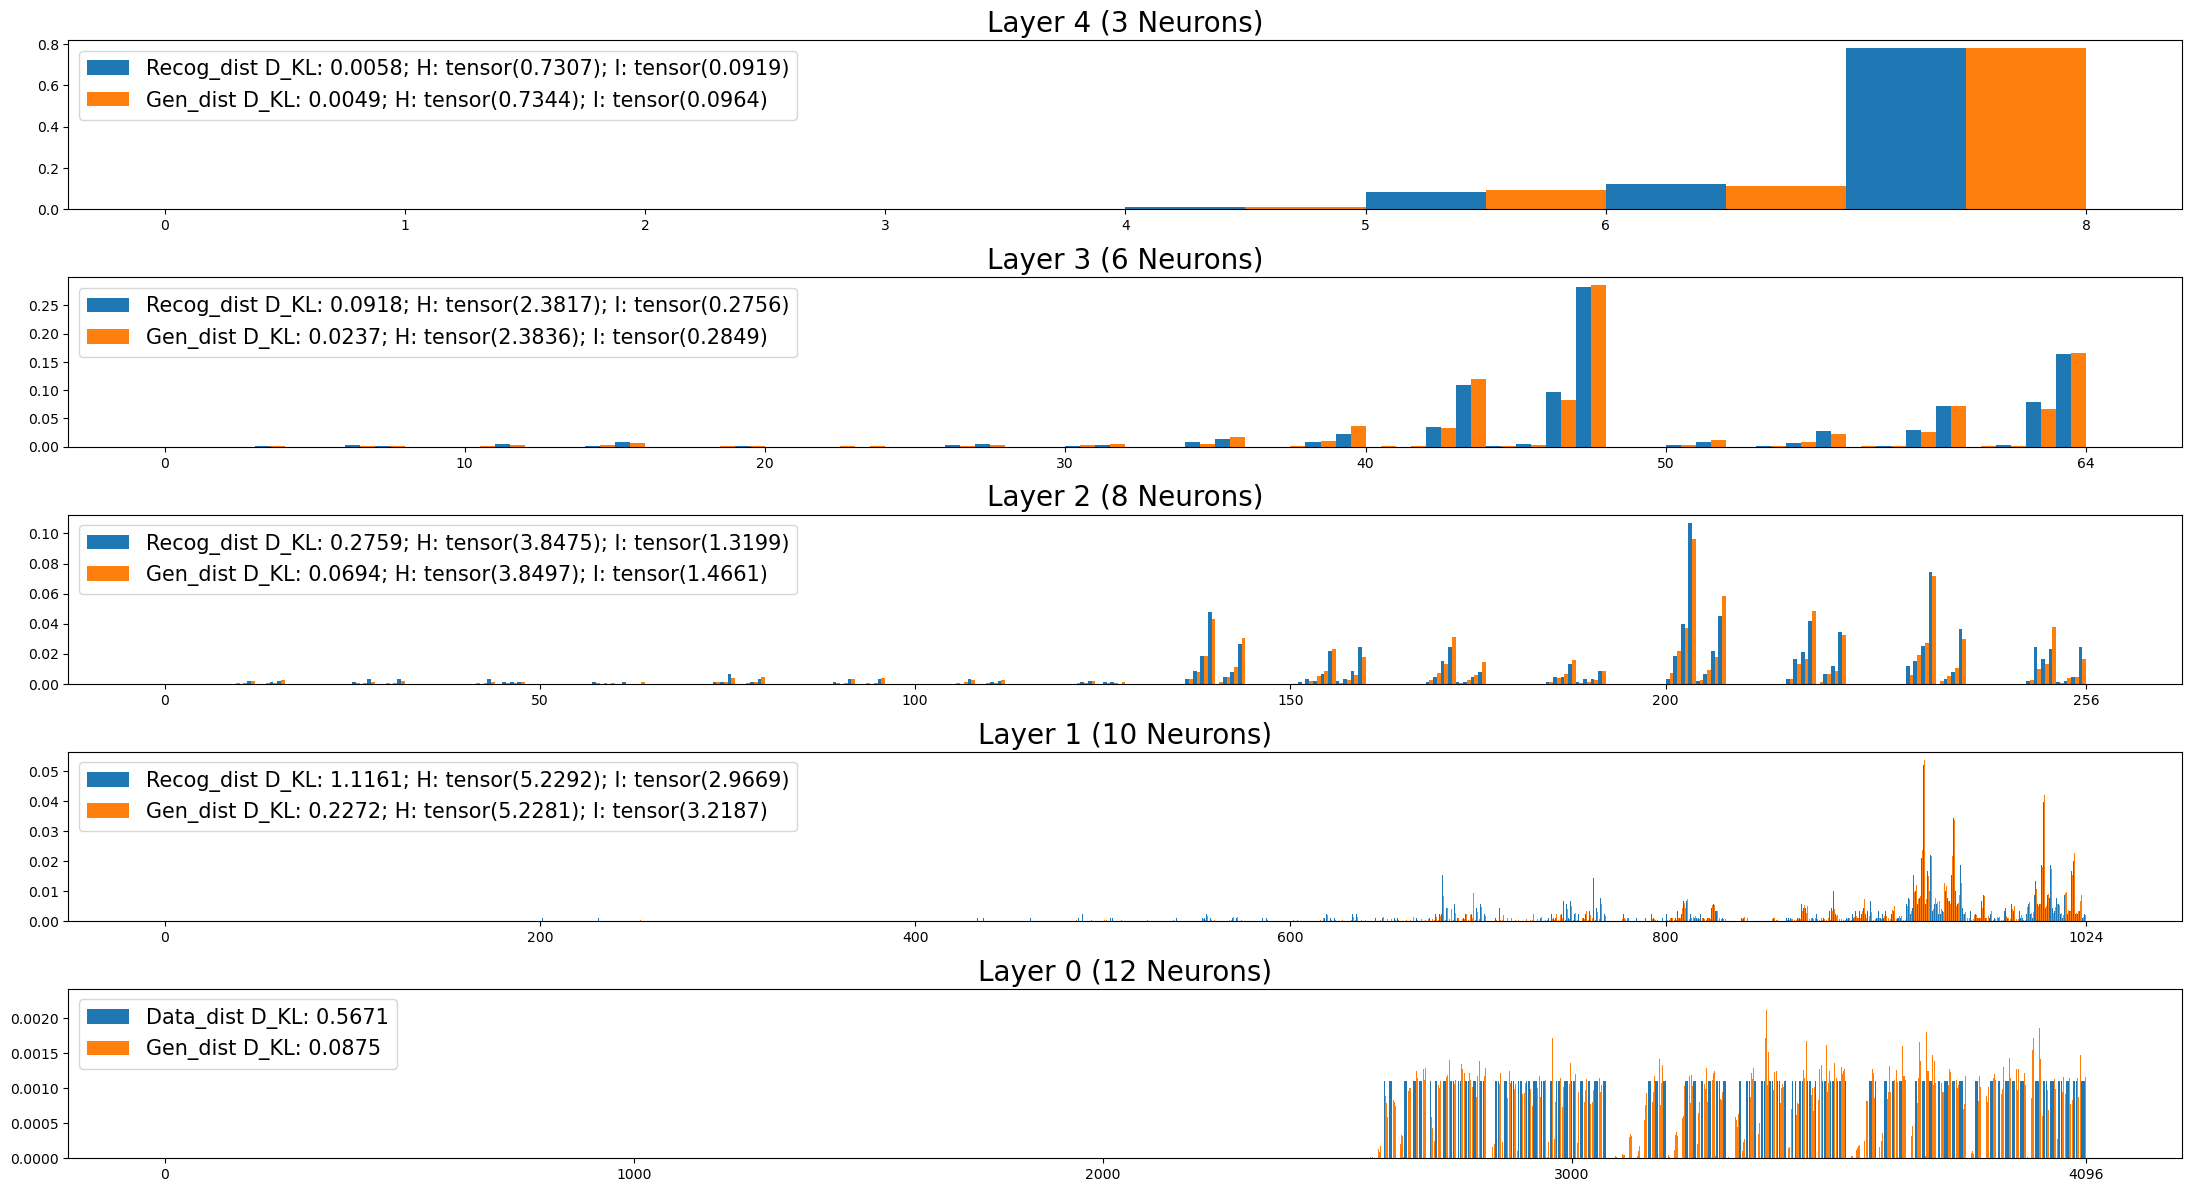

In [132]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)
H_Y_w, I_w = wake_entropy(Phi,data.repeat(1,50),dev)
H_Y_s, I_s = sleep_entropy(Theta,gen_batch_size,dev)
for i in range(n_layer-1):
    dist_w = Dist_wake['Layer_'+str(i)]
    dist_s = Dist_sleep['Layer_'+str(i)]
    D_KL_w = KL_divergence(dist_s,dist_w).item()
    D_KL_s = KL_divergence(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w[i-1],4)), "H(Y|X): "+str(np.around(H_Y_w[i-1]-I_w[i-1],4)),"I_XY: "+str(np.around(I_w[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s[i],4)), "H(Y|X): "+str(np.around(H_Y_s[i]-I_s[i-1],4)),"I_XY: "+str(np.around(I_s[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w[i-1],4))+ "; I: "+ str(np.around(I_w[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s[i],4))+ "; I: "+ str(np.around(I_s[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    

plt.tight_layout(pad=1)    
plt.show()

## 2. Binary Heartbeat Data (Diffusion Model)

Simple binary sequences of length 20, where a 1 occurs every 5th time bin, and the remainder of the bins are 0.

In [143]:
Data_heartbeat = torch.zeros(20,5,dtype=int,device=dev)
for i in range(5):
    Data_heartbeat[np.arange(i,20+i,5),i] = 1

In [144]:
Data_heartbeat

tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]], device='cuda:0')

In [145]:
decimalize(Data_heartbeat,dev)

tensor([541200, 270600, 135300,  67650,  33825], device='cuda:0')

In [156]:
structure = [20,10,5,1]
n_dz = torch.tensor(structure)
n_layer = len(n_dz)
n_d = n_dz[0]

In [165]:
data = Data_heartbeat.repeat(1,200)
data.shape

torch.Size([20, 1000])

In [166]:
n_data = data.shape[1]
n_data

1000

In [159]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Data_D_KL')
col_list.append('Gen_D_KL')
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Data_D_KL',
 'Gen_D_KL',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2']

In [160]:
data_dcm = decimalize(data,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [213]:
Analytic_heartbeat_batch_cor = pd.read_csv('Analytic_heartbeat_batch.csv', sep=",")
Analytic_heartbeat_batch_cor

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Data_D_KL,Gen_D_KL,Recog_H_Layer_1,Recog_H_Layer_2,Recog_I_Layer_1,Recog_I_Layer_2,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_I_Layer_1,Gen_I_Layer_2
0,0.693147,0.693147,0.693147,0.693147,0.693147,9.213539,18.390564,6.931467,3.465734,0.000003,0.000001,13.848907,6.931467,3.465735,0.001408,0.000001
1,0.619926,0.655682,0.427013,0.671477,0.661292,9.213539,18.390564,6.719806,3.318262,0.568405,0.020708,10.697159,6.769458,3.323036,1.020173,0.052652
2,0.501150,0.646734,0.127194,0.644013,0.663958,9.213539,18.390564,6.480569,3.308590,2.260213,0.032035,9.826911,6.618881,3.308780,3.986944,0.103664
3,0.481474,0.632323,0.090554,0.629309,0.658097,9.213539,18.390564,6.436086,3.299257,2.216810,0.129522,9.787395,6.525911,3.302158,5.057149,0.187354
4,0.462218,0.573708,0.073964,0.587549,0.650301,9.213539,18.390564,6.420018,3.279249,2.238321,0.401135,9.871145,6.479797,3.279486,5.800536,0.472674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.474868,0.449845,0.002749,0.560721,0.615080,0.363660,0.037263,6.534413,3.107238,1.758887,0.836486,10.063131,6.528497,3.104880,9.823909,0.978347
496,0.473164,0.451530,0.003781,0.553203,0.622958,0.363660,0.037263,6.531655,3.117494,1.763172,0.833233,10.062110,6.529897,3.125015,9.821972,0.977866
497,0.473658,0.450129,0.002195,0.558179,0.624436,0.363660,0.037263,6.533324,3.102585,1.761343,0.830331,10.066860,6.534811,3.110161,9.821468,0.975015
498,0.478032,0.453090,0.005592,0.556777,0.627852,0.363660,0.037263,6.531760,3.120260,1.758333,0.836296,10.064075,6.527331,3.127481,9.818883,0.980788


In [214]:
para = np.load('Parameters_heartbeat_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [215]:
Theta['Theta_10'] = torch.cat((Theta['Theta_10'],torch.zeros(n_d,n_d-1,device=dev)),1)
Theta['Theta_10'].shape

torch.Size([20, 29])

In [224]:
batch_size = n_data
gen_batch_size = 100000
lr = 0.1
epoch = 90000
n_data

1000

In [1]:
# for e in range(epoch):
# #     if e%10 == 0:
#     Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,cor=True)
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev,cor=True)
# #     else:
# #         Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,cor=False)
# #         Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev,cor=False)
#     print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
#     if e%1000 == 0:
#         stat = []
#         stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
#         stat = stat + list((Loss_sleep).to('cpu').numpy())
        
#         gen_data = sleep_sample(Theta,gen_batch_size,dev,cor=True)["Layer_0"]
#         values_g,counts_g = torch.unique(decimalize(gen_data,dev),return_counts=True)
#         gen_dist = torch.zeros(2**n_d,device=dev)
#         gen_dist[values_g]=counts_g/gen_batch_size

#         stat.append(KL_divergence(gen_dist,data_dist).item())
#         stat.append(KL_divergence(data_dist,gen_dist).item())
        
#         H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev) # batch_size = 50000
#         H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
#         stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
#                 + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
#         Analytic_heartbeat_batch_cor.loc[len(Analytic_heartbeat_batch_cor)] = stat

In [226]:
Analytic_heartbeat_batch_cor

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Data_D_KL,Gen_D_KL,Recog_H_Layer_1,Recog_H_Layer_2,Recog_I_Layer_1,Recog_I_Layer_2,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_I_Layer_1,Gen_I_Layer_2
0,0.693147,0.693147,0.693147,0.693147,0.693147,9.213539,18.390564,6.931467,3.465734,0.000003,0.000001,13.848907,6.931467,3.465735,0.001408,0.000001
1,0.619926,0.655682,0.427013,0.671477,0.661292,9.213539,18.390564,6.719806,3.318262,0.568405,0.020708,10.697159,6.769458,3.323036,1.020173,0.052652
2,0.501150,0.646734,0.127194,0.644013,0.663958,9.213539,18.390564,6.480569,3.308590,2.260213,0.032035,9.826911,6.618881,3.308780,3.986944,0.103664
3,0.481474,0.632323,0.090554,0.629309,0.658097,9.213539,18.390564,6.436086,3.299257,2.216810,0.129522,9.787395,6.525911,3.302158,5.057149,0.187354
4,0.462218,0.573708,0.073964,0.587549,0.650301,9.213539,18.390564,6.420018,3.279249,2.238321,0.401135,9.871145,6.479797,3.279486,5.800536,0.472674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.480186,0.472516,0.000324,0.570138,0.617309,0.043080,0.004580,6.545443,3.107200,1.722217,0.760270,10.010187,6.544601,3.106772,9.979165,0.863284
596,0.478779,0.478337,0.000202,0.571402,0.621869,0.044671,0.004699,6.546218,3.124101,1.721792,0.754568,10.010893,6.546886,3.123768,9.977192,0.868444
597,0.479158,0.478673,0.000183,0.567113,0.619774,0.044100,0.004666,6.544060,3.118555,1.721442,0.756260,10.010843,6.545557,3.118343,9.977128,0.867753
598,0.479557,0.474119,0.000184,0.566996,0.620196,0.042179,0.004369,6.536033,3.107142,1.718611,0.748176,10.010822,6.536094,3.106119,9.978743,0.855193


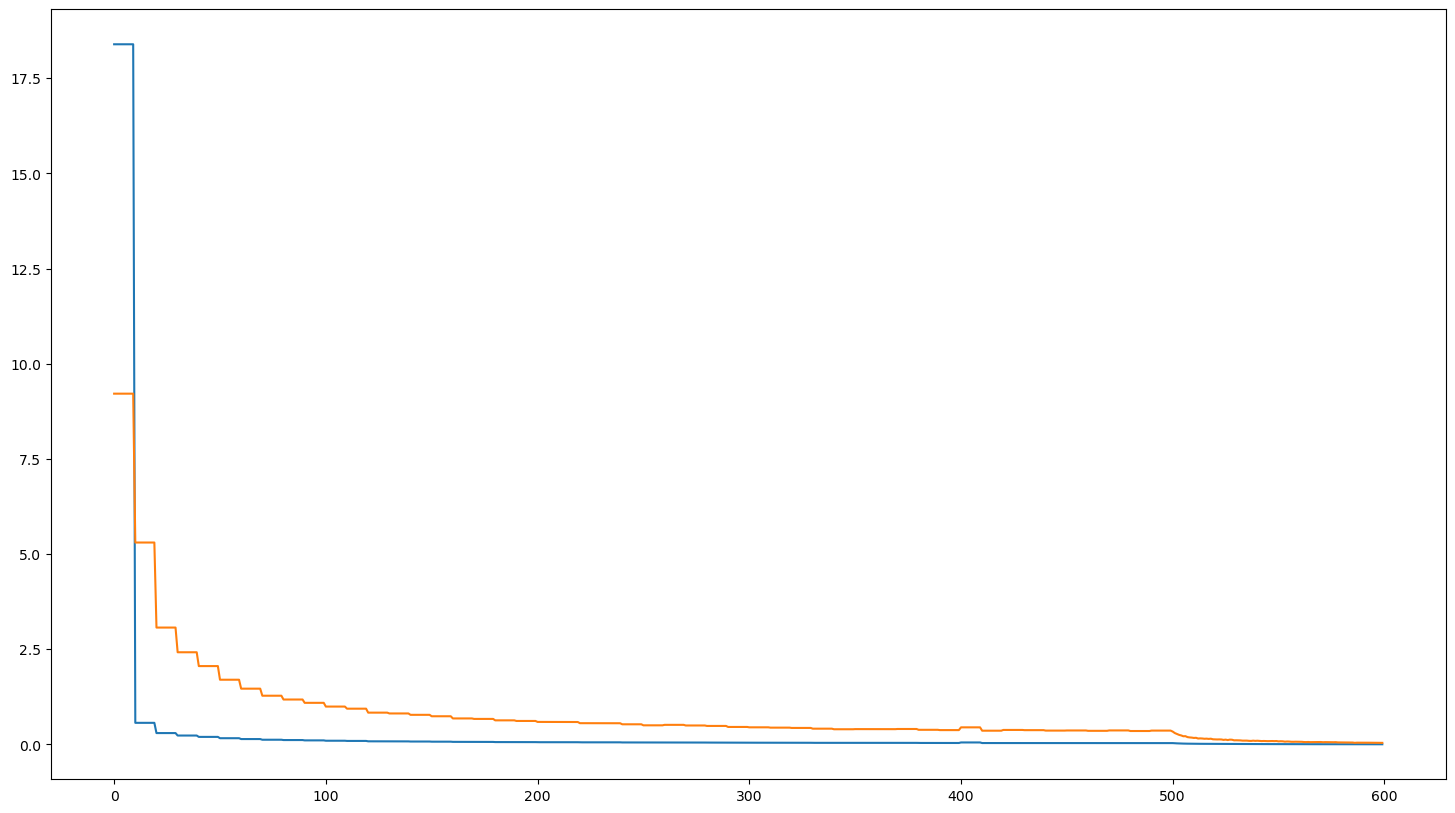

In [227]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_heartbeat_batch_cor['Gen_D_KL']))
ax.plot(np.array(Analytic_heartbeat_batch_cor['Data_D_KL']))
plt.show()

In [228]:
parameters = {'Phi': Phi, 'Theta': Theta}
torch.save(parameters,'Parameters_heartbeat_batch_cor')

In [229]:
Analytic_heartbeat_batch_cor.to_csv('Analytic_heartbeat_batch_cor.csv', index = False)

In [230]:
heartbeat_pattern = decimalize(Data_heartbeat,dev)
heartbeat_pattern

tensor([541200, 270600, 135300,  67650,  33825], device='cuda:0')

In [231]:
gen_data = sleep_sample(Theta,gen_batch_size,dev,cor=True)["Layer_0"]
values_g,counts_g = torch.unique(decimalize(gen_data,dev),return_counts=True)
gen_stat = torch.zeros(6,device=dev)
for i in range(5):
    gen_stat[i] = counts_g[torch.where(values_g == heartbeat_pattern[i])][0]
gen_stat[-1] = counts_g.sum() - gen_stat.sum()
gen_stat = gen_stat/counts_g.sum()
gen_stat

tensor([0.1980, 0.2014, 0.1994, 0.1967, 0.1998, 0.0046], device='cuda:0')

In [232]:
1-0.0046

0.9954

### Plot Analytic

In [57]:
Analytic = Analytic_well_formed_batch_cor
Analytic

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,8.517877,...,4.768372e-07,8.314627,6.931460,5.545170,4.158881,2.079441,0.000320,0.000004,0.000002,0.000002
1,0.686657,0.690722,0.692021,0.690250,0.612048,0.684426,0.690240,0.692160,0.691834,3.726403,...,6.158352e-04,7.408446,6.852787,5.526151,4.154981,2.076340,0.033911,0.009284,0.003294,0.001352
2,0.681345,0.687987,0.689541,0.682218,0.611148,0.684541,0.688435,0.690330,0.686892,3.644928,...,3.796577e-03,7.390693,6.846466,5.510879,4.144400,2.058817,0.045403,0.010573,0.005669,0.004341
3,0.674804,0.685975,0.686745,0.673212,0.601985,0.683548,0.686984,0.684644,0.681567,3.512707,...,6.826639e-03,7.381727,6.844646,5.496471,4.127330,2.035040,0.121571,0.011034,0.007671,0.008052
4,0.658424,0.682750,0.682672,0.658611,0.584376,0.682454,0.683092,0.680933,0.665884,3.184795,...,1.136386e-02,7.373665,6.826271,5.477844,4.104737,1.996639,0.299424,0.013454,0.009907,0.011582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.251868,0.316527,0.410392,0.268275,0.332137,0.366553,0.497466,0.465560,0.294487,0.677869,...,1.317491e-01,7.335526,5.701438,4.491810,2.924160,0.875635,3.359627,2.144290,0.469572,0.139247
326,0.257132,0.312018,0.412972,0.243740,0.326479,0.357293,0.509497,0.471025,0.285421,0.664728,...,1.354845e-01,7.333112,5.707237,4.509664,2.947655,0.881995,3.355841,2.157112,0.479871,0.141514
327,0.258495,0.314221,0.408657,0.245219,0.325884,0.358253,0.508138,0.463709,0.287413,0.656104,...,1.331169e-01,7.332712,5.684342,4.499578,2.916951,0.886251,3.349450,2.144201,0.473807,0.141391
328,0.255879,0.319355,0.414813,0.232300,0.331659,0.348567,0.504297,0.468771,0.299326,0.661331,...,1.377692e-01,7.332651,5.694893,4.489432,2.919247,0.889228,3.352013,2.158233,0.468841,0.143123


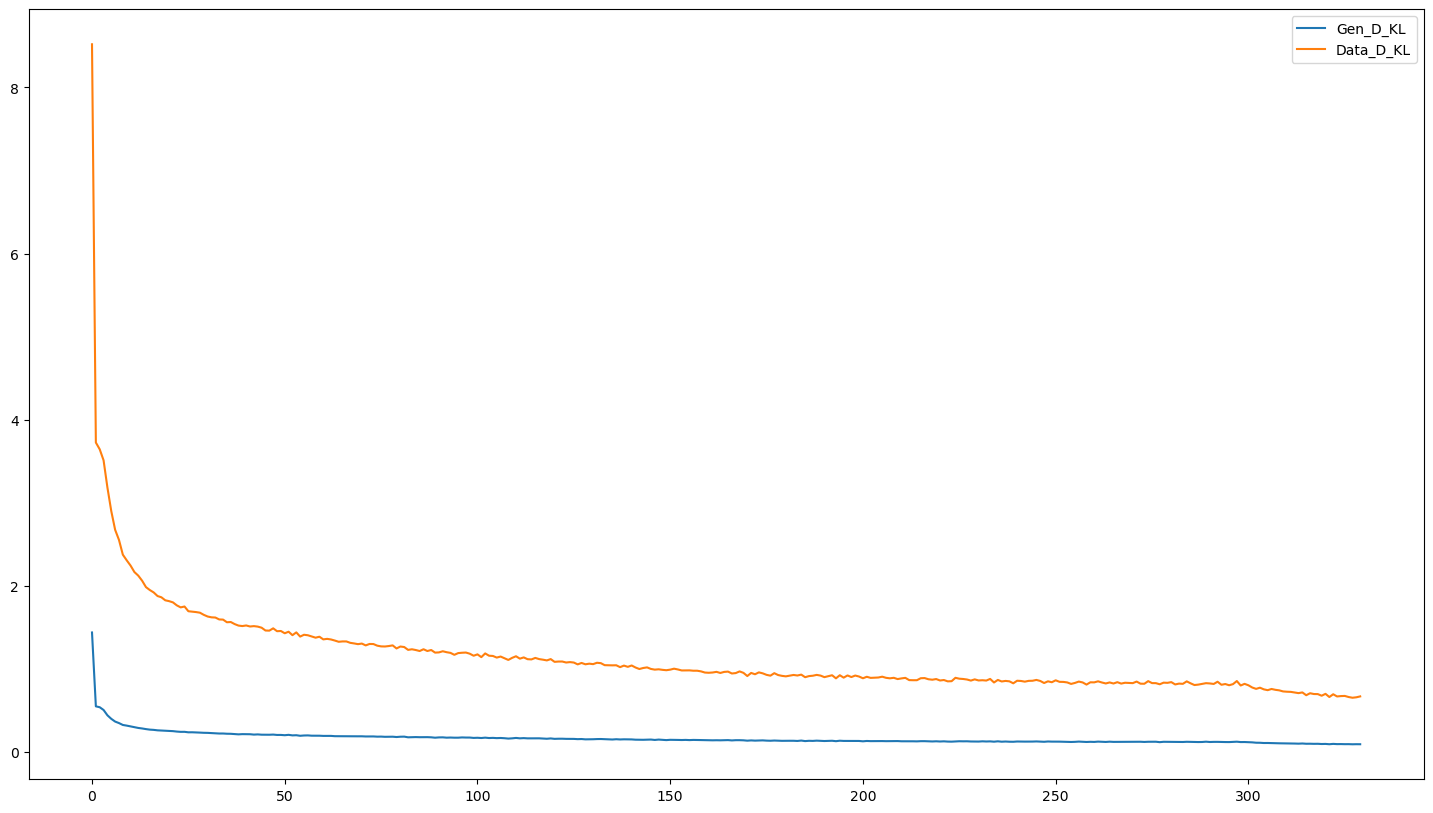

In [58]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Gen_D_KL']),label = 'Gen_D_KL')
# ax.plot(np.array(Analytic['Data_D_KL'])/np.array(Analytic['Data_D_KL']).mean()*np.array(Analytic['Gen_D_KL']).mean(),label='Data_D_KL')
ax.plot(np.array(Analytic['Data_D_KL']),label = 'Data_D_KL')
ax.legend()
plt.show()

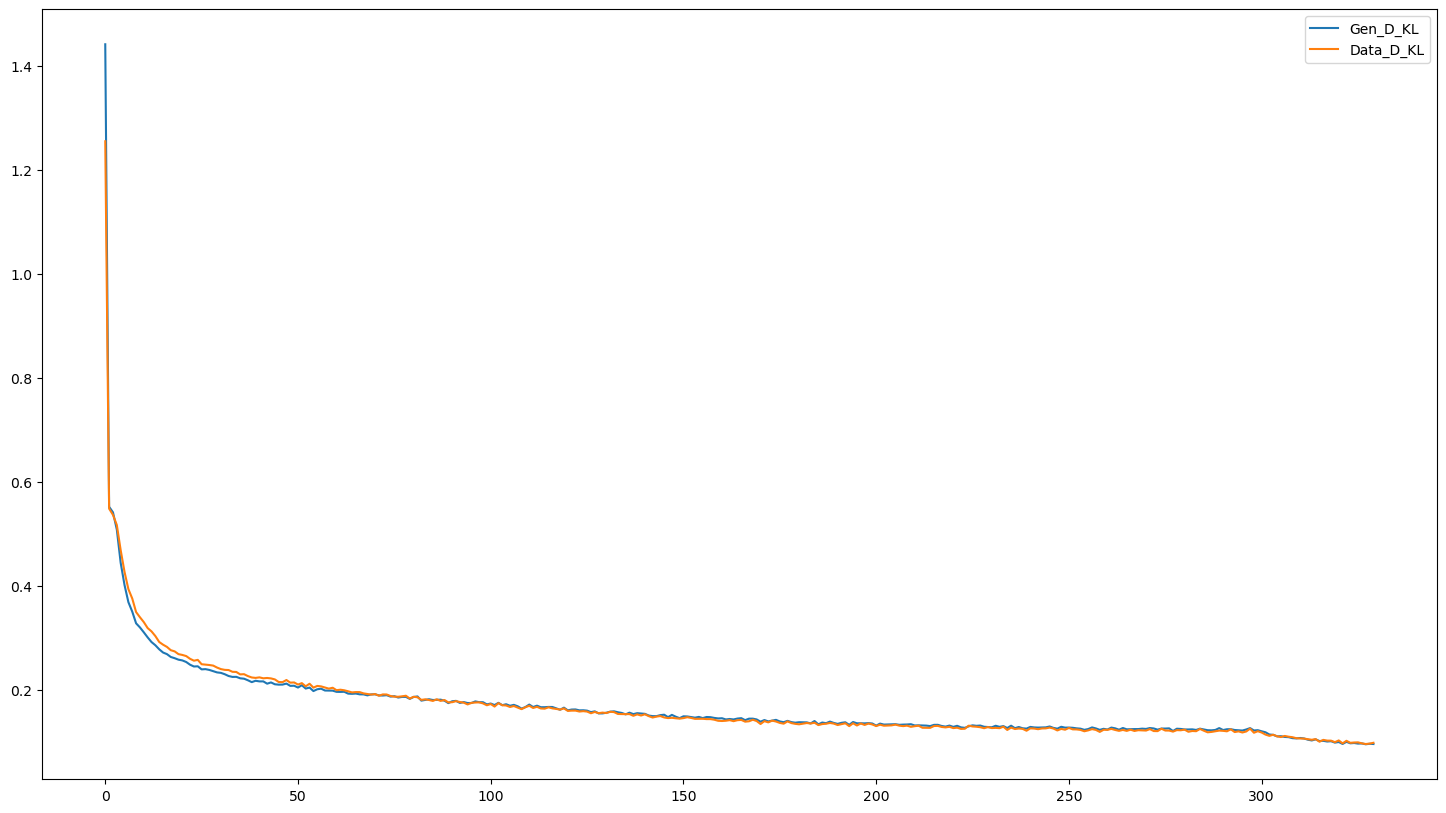

In [59]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Gen_D_KL']),label = 'Gen_D_KL')
ax.plot(np.array(Analytic['Data_D_KL'])/np.array(Analytic['Data_D_KL']).mean()*np.array(Analytic['Gen_D_KL']).mean(),label='Data_D_KL')
# ax.plot(np.array(Analytic['Data_D_KL']),label = 'Data_D_KL')
ax.legend()
plt.show()

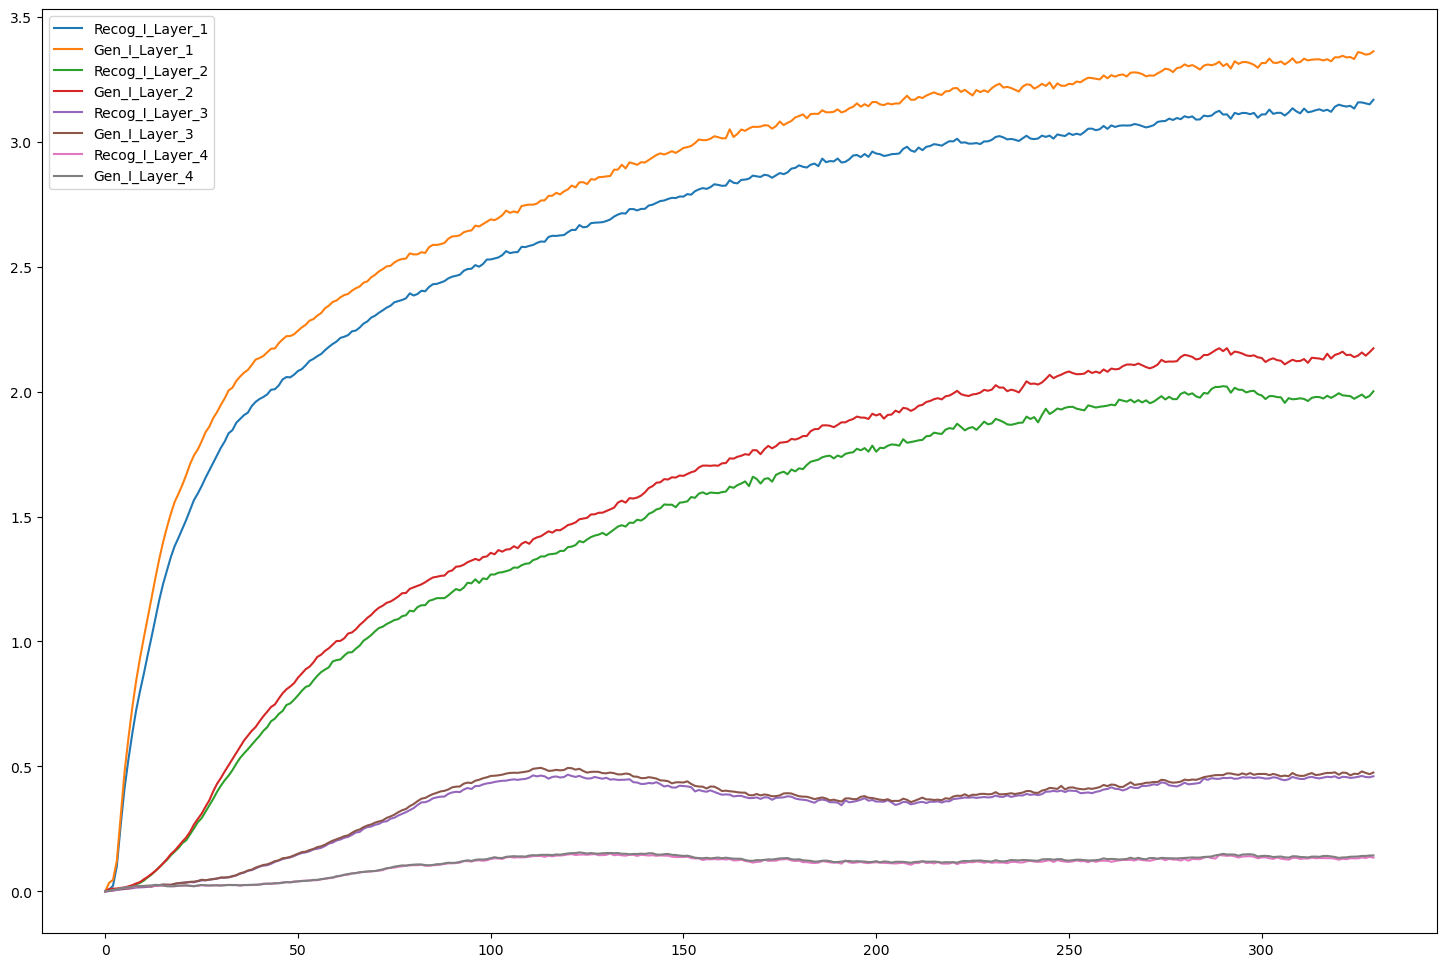

In [60]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

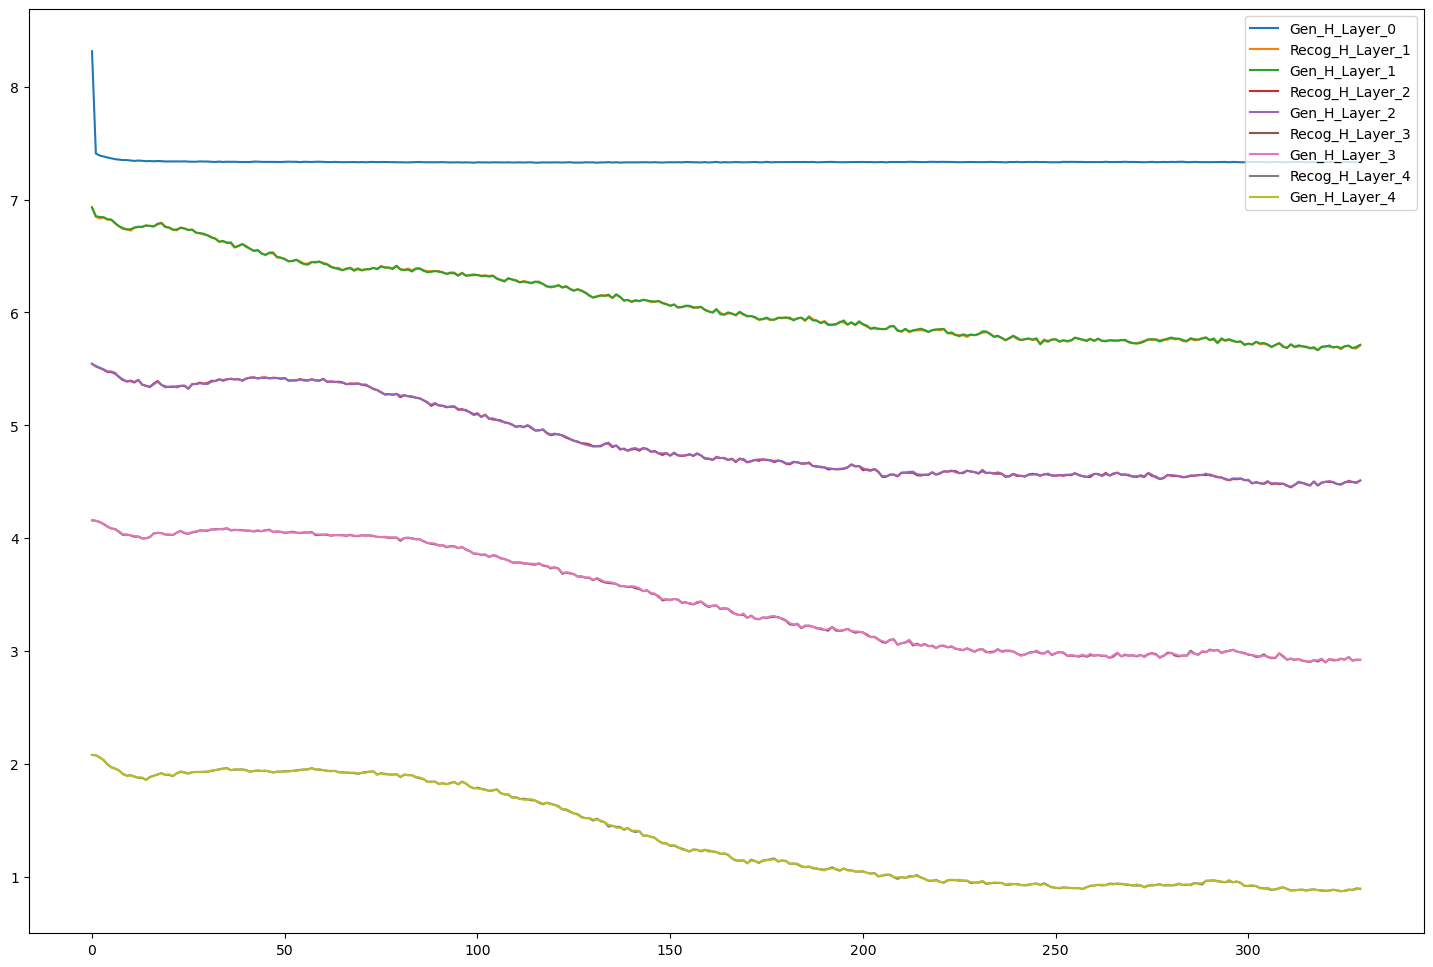

In [61]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [62]:
n_dz * np.log(2)

tensor([8.3178, 6.9315, 5.5452, 4.1589, 2.0794, 0.6931])

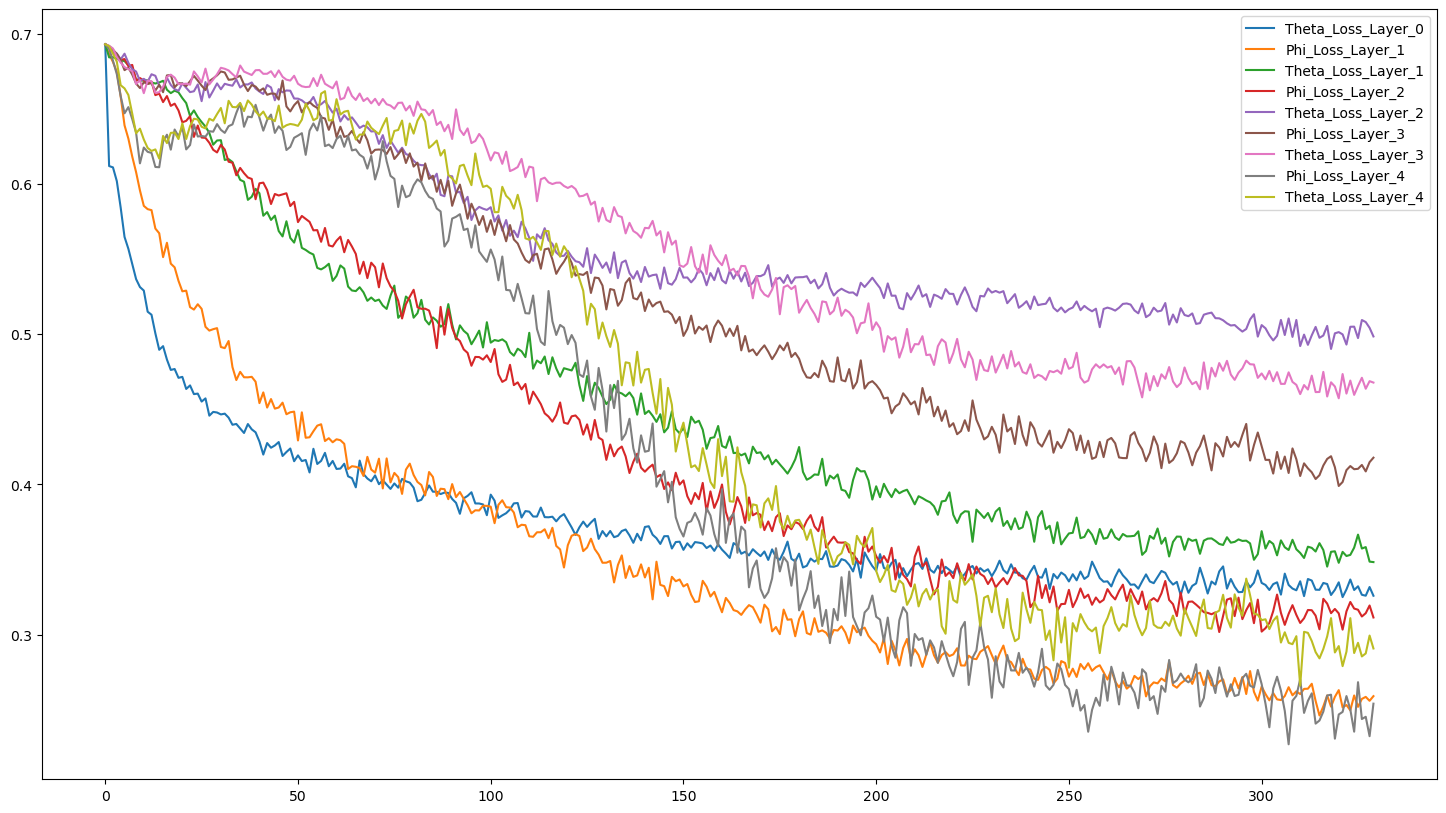

In [63]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

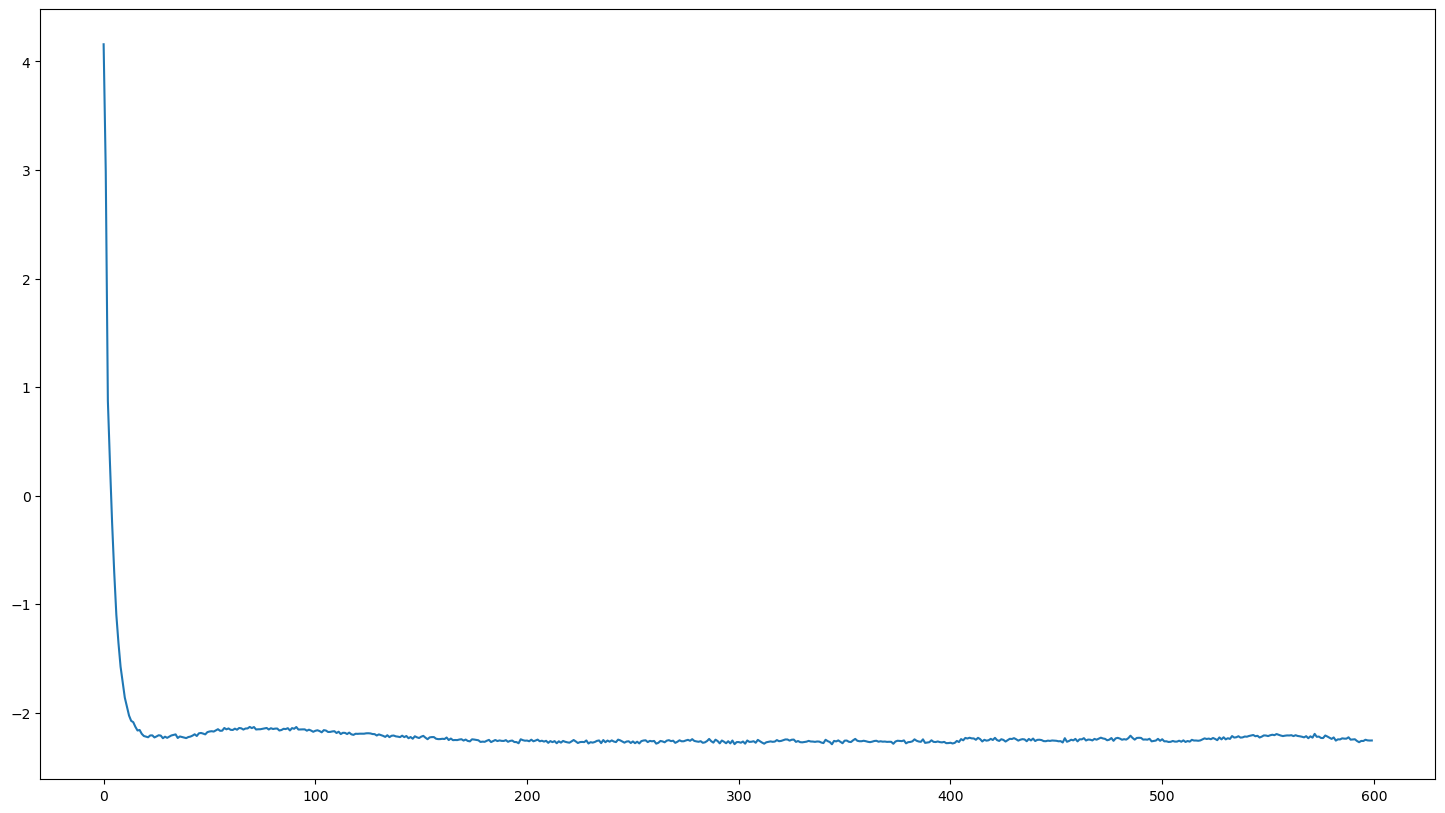

In [240]:
# normalized loss
Loss = 2*(np.array(Analytic['Theta_Loss_Layer_'+str(0)])-(np.array(Analytic['Gen_I_Layer_1'])/structure[i]))
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)]))/structure[i]
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)])/structure[n_layer-2]
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(Loss)
plt.show()

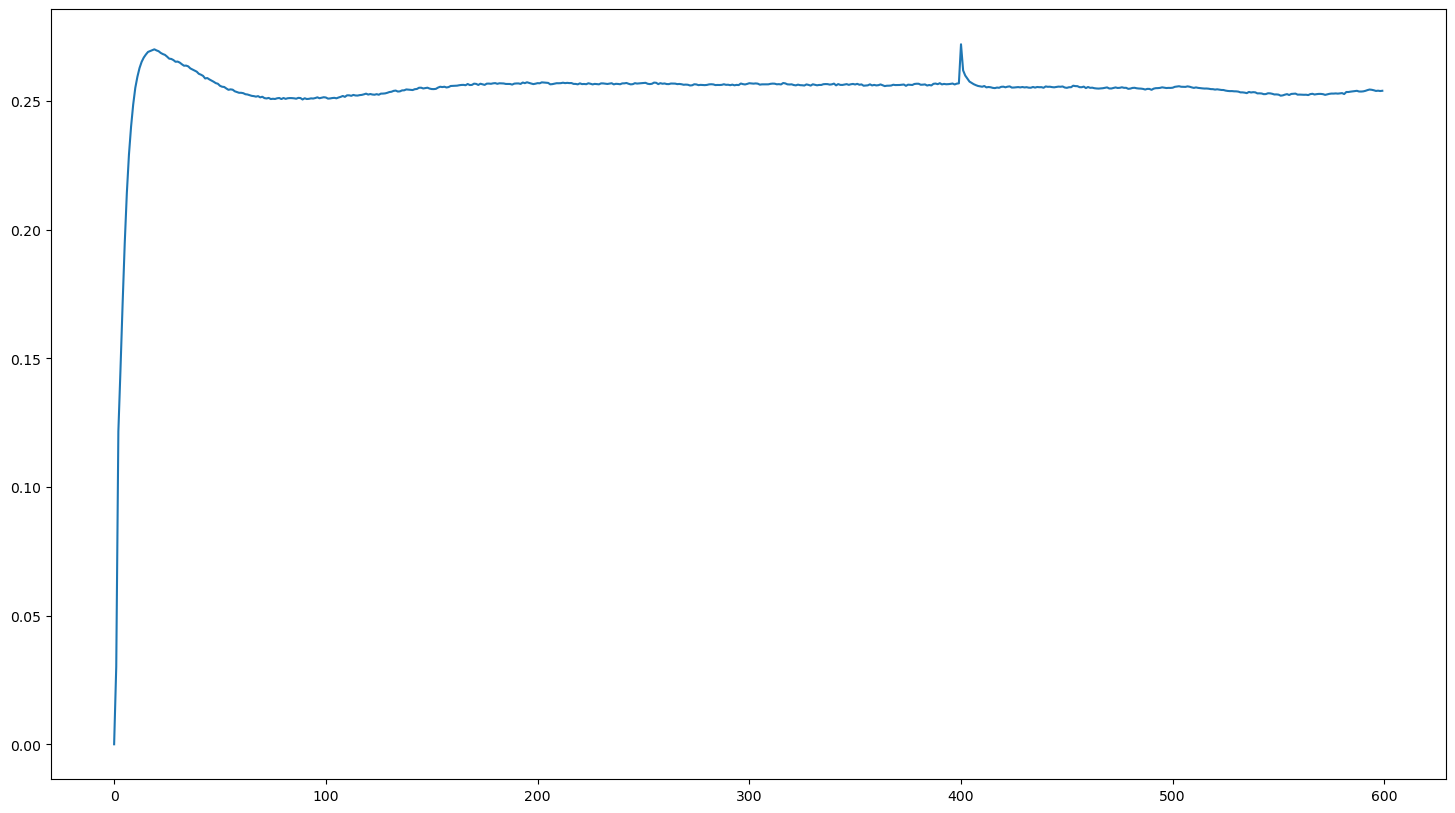

In [241]:
# normalized mutual information
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(I/H)
plt.show()